# 

c:/temp/ny/global.GDB
found your hucpoly:  02020006
input point is type "global" 398
localGDB: c:/temp/ny/02020006/02020006.gdb
found your catchment. HydroID is:  692
input point is type "localGlobal"
found upstream adjointCatchment
is global
in recursive loop [] []
junction count: ["JunctionID = '65'", "JunctionID = '10'"]


Text(0.5, 1.0, 'Merged Catchment boundary (vector)')

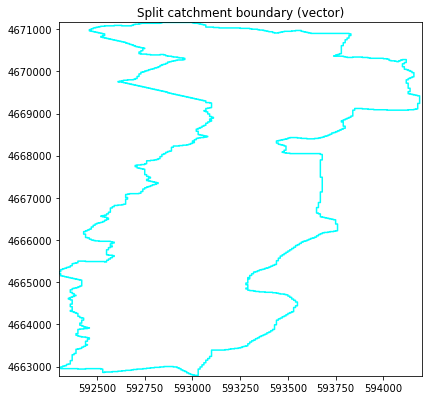

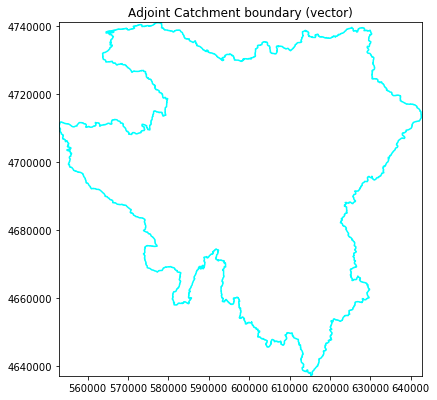

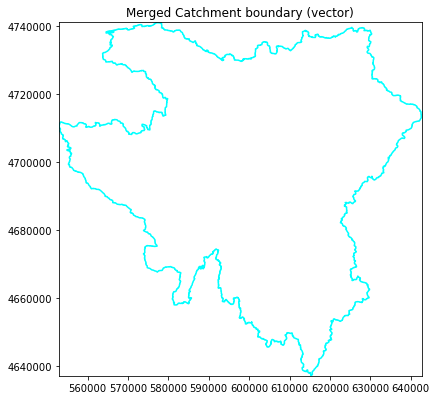

In [10]:
##initialize

import argparse
import sys
from osgeo import ogr, gdal
from pysheds.grid import Grid
import matplotlib.pyplot as plt
import numpy as np
import json

#arguments
GLOBAL_GDB = 'global.GDB'
HUCPOLY_LAYER = 'hucpoly'
HUCPOLY_LAYER_ID = 'NAME'
HUCPOLY_LAYER_JUNCTION_ID = 'JunctionID'
GLOBAL_STREAM_LAYER = ['streams3d', 'streams']
GLOBAL_STREAM_LAYER_ID = 'HydroID'
HUC_NET_JUNCTIONS_LAYER = ['Huc_net_Junctions3D','Huc_net_Junctions']
HUC_NET_JUNCTIONS_LAYER_ID = ['Point2DID', 'HydroID']
CATCHMENT_LAYER = 'Catchment'
CATCHMENT_LAYER_ID = 'HydroID'
ADJOINT_CATCHMENT_LAYER = 'AdjointCatchment'
ADJOINT_CATCHMENT_LAYER_ID = 'DrainID'
DRAINAGE_LINE_LAYER = 'DrainageLine'
DRAINAGE_LINE_LAYER_ID = 'DrainID'
POINT_BUFFER_DISTANCE = 50 #in local projection units

#local
# x = -73.74586
# y = 44.00683

#localGlobal
# x = -73.71348
# y = 44.00431

#global non-nested upstream
# x = -73.82705
# y = 43.29139

#global nested upstream
x = -73.87555
y = 42.17209


region = 'ny'
globalDataPath = 'c:/temp/' + region + '/'
globalGDB = globalDataPath + GLOBAL_GDB

print(globalGDB)

huc_net_junction_list = []
upstream_huc_list = []

def searchPolygonForJunctions(polygon):
    
    print('in recursive loop',upstream_huc_list,huc_net_junction_list)
    
    #get list of huc_net_junctions using merged catchment geometry
    hucNetJunctionsLayer.SetSpatialFilter(None)
    hucNetJunctionsLayer.SetSpatialFilter(polygon)

    junction_count = 0
    for hucNetJunctions_feat in hucNetJunctionsLayer:
        junction_count += 1
        hucNetJunctionsID = hucNetJunctions_feat.GetFieldAsString(hucNetJunctionsIdIndex)
        s = (HUCPOLY_LAYER_JUNCTION_ID + " = '" + hucNetJunctionsID + "'")
        huc_net_junction_list.append(s)

    print('junction count:', huc_net_junction_list)
    
    #i think were done if there are only 2
    if junction_count == 2:
        return;
    
    #set attribute filter
    operator = " OR "
    huc_net_junction_string = operator.join(huc_net_junction_list) 
    hucLayer.SetAttributeFilter(None)
    hucLayer.SetAttributeFilter(huc_net_junction_string)
    print('huc_net_junction selection string:',huc_net_junction_string)
    
    for huc_select_feat in hucLayer:
        huc_name = huc_select_feat.GetFieldAsString(hucNameFieldIndex)
        upstreamHUC = huc_select_feat.GetGeometryRef()
        upstream_huc_list.append(huc_name)

        print('found upstream global HUC:', huc_name)
        print('upstream HUC list:',upstream_huc_list)
        
        #recursive call
        searchPolygonForJunctions(upstreamHUC)

        

## ---------------------------------------------------------
## START GLOBAL GDB PROCESS
## ---------------------------------------------------------
# use OGR specific exceptions
ogr.UseExceptions()

# get the driver
driver = ogr.GetDriverByName("OpenFileGDB")

# opening the FileGDB
try:
    global_gdb = driver.Open(globalGDB, 0)
except e:
    print('Check to make sure you have a global gdb for:', region)
    sys.exit()

#get polygon layer to query
try:
    hucLayer = global_gdb.GetLayer(HUCPOLY_LAYER)
except:
    print('ERROR: Looks like you are missing the hucpoly layer for:', region)

#there are at least two possible global stream layer names
try:
    globalStreamsLayer = global_gdb.GetLayer(GLOBAL_STREAM_LAYER[0])
except:
    globalStreamsLayer = global_gdb.GetLayer(GLOBAL_STREAM_LAYER[1])
    
#there are at least two possible huc_net_junctions layer names
## ONLY NEED TO DO THIS IF GLOBAL
try:
    hucNetJunctionsLayer = global_gdb.GetLayer(HUC_NET_JUNCTIONS_LAYER[0])
except:
    hucNetJunctionsLayer = global_gdb.GetLayer(HUC_NET_JUNCTIONS_LAYER[1])

#Put the title of the field you are interested in here
hucNameFieldIndex = hucLayer.GetLayerDefn().GetFieldIndex(HUCPOLY_LAYER_ID)
globalStreamsHydroIdIndex = globalStreamsLayer.GetLayerDefn().GetFieldIndex(GLOBAL_STREAM_LAYER_ID)
try:
    hucNetJunctionsIdIndex = hucNetJunctionsLayer.GetLayerDefn().GetFieldIndex(HUC_NET_JUNCTIONS_LAYER_ID[0])
except:
    hucNetJunctionsIdIndex = hucNetJunctionsLayer.GetLayerDefn().GetFieldIndex(HUC_NET_JUNCTIONS_LAYER_ID[1])

#The following assumes that the latitude longitude is in WGS84 ("EPSG:4326")
#We will create a transformation between this and the hucpoly projection
geo_ref = hucLayer.GetSpatialRef()
point_ref=ogr.osr.SpatialReference()
point_ref.ImportFromEPSG(4326)
ctran=ogr.osr.CoordinateTransformation(point_ref,geo_ref)

#Transform incoming longitude/latitude to the hucpoly projection
[projectedLng,projectedLat,z]=ctran.TransformPoint(x,y)

#Create a point
inputPointProjected = ogr.Geometry(ogr.wkbPoint)
inputPointProjected.SetPoint_2D(0, projectedLng, projectedLat)

#find the HUC the point is in
hucLayer.SetSpatialFilter(inputPointProjected)

#Loop through the overlapped features and display the field of interest
for hucpoly_feat in hucLayer:
    hucName = hucpoly_feat.GetFieldAsString(hucNameFieldIndex)
    print('found your hucpoly: ',hucName)

    #store local path info now that we know it
    localDataPath = globalDataPath + hucName + '/'
    localGDB = localDataPath + hucName + '.gdb'
    
#clear hucLayer spatial filter
hucLayer.SetSpatialFilter(None)
    
####  NEED TO BUFFER INPUT POINTS FOR QUERYING LINES ######
bufferPoint = inputPointProjected.Buffer(POINT_BUFFER_DISTANCE)
globalStreamsLayer.SetSpatialFilter(bufferPoint)

#Loop through the overlapped features and display the field of interest
isGlobal = False
for stream_feat in globalStreamsLayer:
    globalStreamID = stream_feat.GetFieldAsString(globalStreamsHydroIdIndex)
    print('input point is type "global"', globalStreamID)
    isGlobal = True
    

print('localGDB:', localGDB)

## ---------------------------------------------------------
## END GLOBAL GDB PROCESS
## ---------------------------------------------------------


## ---------------------------------------------------------
## START LOCAL GDB PROCESS
## ---------------------------------------------------------
# use OGR specific exceptions
ogr.UseExceptions()

# get the driver
driver = ogr.GetDriverByName("OpenFileGDB")

# opening the FileGDB
try:
    local_gdb = driver.Open(localGDB, 0)
except e:
    print('Check to make sure you have a local gdb for:', region)
    sys.exit()

#define local data layers
try:
    catchmentLayer = local_gdb.GetLayer(CATCHMENT_LAYER)
    adjointCatchmentLayer = local_gdb.GetLayer(ADJOINT_CATCHMENT_LAYER)
    drainageLineLayer = local_gdb.GetLayer(DRAINAGE_LINE_LAYER)
except:
    print('ERROR: make sure you have data for the local HUC:', hucName)
    
#Put the title of the field you are interested in here
catchmentLayerNameFieldIndex = catchmentLayer.GetLayerDefn().GetFieldIndex(CATCHMENT_LAYER_ID)
adjointCatchmentLayerNameFieldIndex = adjointCatchmentLayer.GetLayerDefn().GetFieldIndex(ADJOINT_CATCHMENT_LAYER_ID)
DrainageLineLayerNameFieldIndex = drainageLineLayer.GetLayerDefn().GetFieldIndex(DRAINAGE_LINE_LAYER_ID)

#Get local catchment
catchmentLayer.SetSpatialFilter(inputPointProjected)
for catchment_feat in catchmentLayer:
    catchmentID = catchment_feat.GetFieldAsString(catchmentLayerNameFieldIndex)
    print('found your catchment. HydroID is: ',catchmentID)
    
#Check if we have a 'localGlobal'
isLocalGlobal = False
drainageLineLayer.SetSpatialFilter(bufferPoint)
for drainage_feat in drainageLineLayer:
    isLocalGlobal = True
    print('input point is type "localGlobal"')
    
    select_string = (ADJOINT_CATCHMENT_LAYER_ID + " = '" + catchmentID + "'")
    adjointCatchmentLayer.SetAttributeFilter(select_string)
    
    for adjointCatchment_feat in adjointCatchmentLayer:
        print('found upstream adjointCatchment')
        adjointCatchmentGeom = adjointCatchment_feat.GetGeometryRef()    

if not isLocalGlobal:
    print('input point is type "local"')

# clean close
del local_gdb

## ---------------------------------------------------------
## START LOCAL GDB PROCESS
## ---------------------------------------------------------


## ---------------------------------------------------------
## START SPLIT CATCHMENT PROCESS
## ---------------------------------------------------------

fdr = localDataPath + 'fdr' 

#writes an output tif clipped to a catchment shapefile in virtual memory
ds = gdal.Warp('/vsimem/fdr.tif', fdr, cutlineDSName = localGDB, cutlineSQL = 'SELECT * FROM Catchment', cutlineWhere = 'HydroID = ' + catchmentID, cropToCutline = True)

#start pysheds catchment delienation
grid = Grid.from_raster('/vsimem/fdr.tif', data_name='dir')
grid.catchment(data='dir', x=projectedLng, y=projectedLat, out_name='catch', recursionlimit=15000, xytype='label')

# Clip the bounding box to the catchment
grid.clip_to('catch')

#some sort of strange raster to polygon conversion using rasterio method
shapes = grid.polygonize()


for shape in shapes:
    splitCatchmentGeom = ogr.CreateGeometryFromJson(json.dumps(shape[0]))
    
#plot split catchment
fig, ax = plt.subplots(figsize=(6.5, 6.5))
coords = np.asarray(shape[0]['coordinates'][0])
ax.plot(coords[:,0], coords[:,1], color='cyan') 
ax.set_xlim(grid.bbox[0], grid.bbox[2])
ax.set_ylim(grid.bbox[1], grid.bbox[3])
ax.set_title('Split catchment boundary (vector)')
    
if isLocalGlobal:

    
    #plot adJoint catchment
    minX, maxX, minY, maxY = adjointCatchmentGeom.GetEnvelope()
    adjointCatchmentJSON = adjointCatchmentGeom.ExportToJson()
    d = json.loads(adjointCatchmentJSON)
    fig, ax = plt.subplots(figsize=(6.5, 6.5))
    coords = np.asarray(d['coordinates'][0][0])
    ax.plot(coords[:,0], coords[:,1], color='cyan') 
    ax.set_xlim(minX, maxX)
    ax.set_ylim(minY, maxY)
    ax.set_title('Adjoint Catchment boundary (vector)')    
    
    #merge geometry
    #splitCatchmentGeom = splitCatchmentGeom.Buffer(10)
    adjointCatchmentGeom = adjointCatchmentGeom.Buffer(1)
    mergedCatchmentGeom = adjointCatchmentGeom.Union(splitCatchmentGeom)
    

if isGlobal:
    print('is global')
    

    #for first recursive global upstream run, use merged catchment geom
    searchPolygonForJunctions(mergedCatchmentGeom)
        
#     upstreamHUCgeom = huc_select_feat.GetGeometryRef() 
#     mergedCatchmentGeom = mergedCatchmentGeom.Union(upstreamHUCgeom)

    
    # clean close
    del global_gdb
    
# Plot merged catchment
minX, maxX, minY, maxY = mergedCatchmentGeom.GetEnvelope() 
mergedCatchmentJSON = mergedCatchmentGeom.ExportToJson()
d = json.loads(mergedCatchmentJSON)
fig, ax = plt.subplots(figsize=(6.5, 6.5))
coords = np.asarray(d['coordinates'][0])
ax.plot(coords[:,0], coords[:,1], color='cyan') 
ax.set_xlim(minX, maxX)
ax.set_ylim(minY, maxY)
ax.set_title('Merged Catchment boundary (vector)')




## ---------------------------------------------------------
## END SPLIT CATCHMENT PROCESS
## ---------------------------------------------------------
